In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import os

from tslearn.datasets import UCR_UEA_datasets

In [2]:
%load_ext autoreload
%autoreload 2

from ksfdtw.distance_measures import nearest_neighbor_interpolation_2d as nearest_neighbor_interpolation

# Import the dataset

The dataset `GunPoint` is imported through `tslearn`.

In [ ]:
dataset_name = "GunPoint"

In [5]:
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

In [6]:
# Backup the original dataset

# Ensure the folder exists
os.makedirs("../data", exist_ok=True)

np.savez(
    "../data/" + dataset_name + ".npz",
    # For X_train
    X_train=X_train,
    y_train=y_train,
    # For X_test
    X_test=X_test,
    y_test=y_test,
)

# Piecewise Scaling

Process the dataset by greedy algorithm with randomness to introduce piecewise scaling distortion as written in `V. EXPERIMENT A. Experimental Setup`.

Create dataset $\mathcal{D}_{\text{train}}^{\text{ps}}$

In [7]:
def preprocess_ts(T, P, l, final_length):

    T = np.asarray(T)
    if T.ndim == 1:
        T = T[:, np.newaxis]  # The format of a univariate time series is (len, 1)
    # Step 1: Compute allowed range for segment lengths
    m = T.shape[0]
    L_avg = m / P
    l_root = math.sqrt(l)  # scaling factor
    L_min = max(1, int(L_avg / l_root))
    L_max = min(int(L_avg * l_root), m)

    # Step 2: generate random lengths in float within the range and normalize to len
    raw = [random.uniform(L_min, L_max) for _ in range(P)]
    # print("raw:", raw)
    scale = m / sum(raw)
    scaled = [r * scale for r in raw]
    # print("scaled:", scaled)

    # Step 3: round to integers, then adjust to sum to len
    int_lengths = [int(round(s)) for s in scaled]
    diff = m - sum(int_lengths)  # Rounding error
    # print("int lengths:", int_lengths)

    # Step 4: fix rounding error
    while diff != 0:
        for i in range(P):
            if diff == 0:
                break
            if diff > 0 and int_lengths[i] < L_max:
                int_lengths[i] += 1
                diff -= 1
            elif diff < 0 and int_lengths[i] > L_min:
                int_lengths[i] -= 1
                diff += 1
    # print("int lengths after fixing of rounding error:", int_lengths)
    # We have a set of P segments with length L_0, L_1, ..., L_{P-1} that sum to m and (max_i L_i)/(min_i L_i) <= l

    segments = []
    cutting_points = []
    interpolated_lengths = []
    start = 0
    for p in range(P):
        # seg_len = random.randint(min_len, max_len)
        # end = min(start + seg_len, original_len)
        end = start + int_lengths[p]
        seg = T[start:end]
        cutting_points.append((start, end))

        # Rescale this segment to a random new length
        new_len = random.randint(L_min, L_max)
        # print(seg.shape)
        seg_rescaled = nearest_neighbor_interpolation(seg, new_len)
        interpolated_lengths.append(seg_rescaled.shape[0])
        # print("seg_rescaled:", seg_rescaled.shape)
        segments.append(seg_rescaled)

        start = end
        if start >= m:
            break
    # Concatenate all interpolated segments
    ts_concat = np.vstack(segments)

    # Compute cutting points on the concatenated sequence (before final rescale)
    cumulative_lengths = np.cumsum(interpolated_lengths)
    # print("cumulative lengths:", cumulative_lengths)
    final_scale_cuts = (
        np.round(cumulative_lengths / cumulative_lengths[-1] * final_length)
        .astype(int)
        .tolist()
    )
    # print("final scale cuts:", final_scale_cuts)

    start = 0
    scaled_cutting_points = []
    for p in range(P):
        end = final_scale_cuts[p]
        scaled_cutting_points.append((start, end))
        start = end
    # print(scaled_cutting_points)

    # Final rescaling to target length
    # print(ts_concat.shape)
    ts_final = nearest_neighbor_interpolation(ts_concat, final_length)

    return ts_final.squeeze(), cutting_points, scaled_cutting_points

In [8]:
# For testing
temp, cutting_points, scaled_cutting_points = preprocess_ts(X_train[0], 3, 2, 150)

([<matplotlib.lines.Line2D at 0x154554c80>], [(0, 47), (47, 96), (96, 150)])

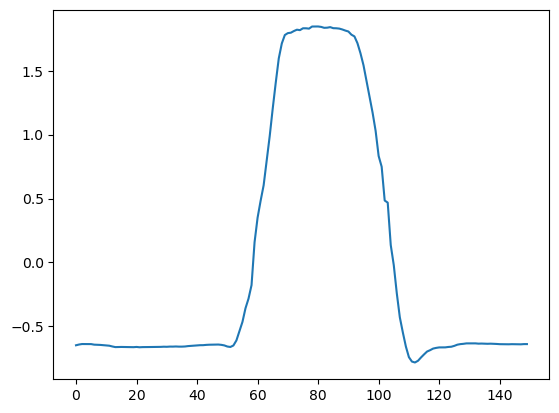

In [9]:
plt.plot(X_train[0]), cutting_points

([<matplotlib.lines.Line2D at 0x15506bf20>], [(0, 56), (56, 95), (95, 150)])

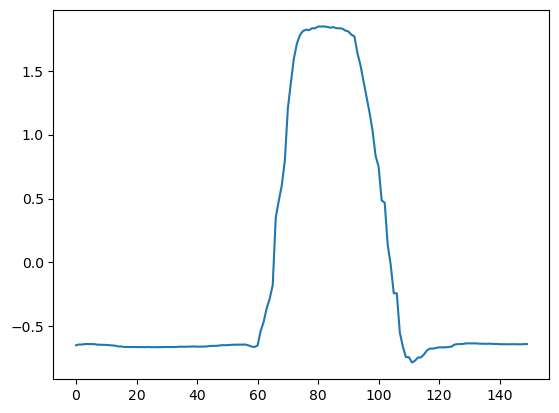

In [10]:
plt.plot(temp), scaled_cutting_points

In [11]:
# ----------------------------
# Parameters
# ----------------------------
P = 3
l = 2.0
final_len = 150

# ----------------------------
# Preprocess Dataset
# ----------------------------
random.seed(42)
# For X_train
X_train_scaled, X_train_ps, X_train_cuts, X_train_ps_cuts = [], [], [], []
for T in X_train:
    X_train_scaled.append(nearest_neighbor_interpolation(T, final_len))
    T_ps, T_cuts, T_ps_cuts = preprocess_ts(T, P, l, final_len)
    X_train_ps.append(T_ps)
    X_train_cuts.append(T_cuts)
    X_train_ps_cuts.append(T_ps_cuts)

# For X_test
X_test_scaled, X_test_ps, X_test_cuts, X_test_ps_cuts = [], [], [], []
for T in X_test:
    X_test_scaled.append(nearest_neighbor_interpolation(T, final_len))
    T_ps, T_cuts, T_ps_cuts = preprocess_ts(T, P, l, final_len)
    X_test_ps.append(T_ps)
    X_test_cuts.append(T_cuts)
    X_test_ps_cuts.append(T_ps_cuts)

X_train_ps = np.array(X_train_ps)
X_train_scaled = np.array(X_train_scaled)
X_test_ps = np.array(X_test_ps)
X_test_scaled = np.array(X_test_scaled)

# Add Gaussian Nose
To create $\mathcal{D}_{\text{train}}^{\text{ps, noise}}$

In [12]:
# Add Class-Dependent Gaussian Noise
def add_class_dependent_noise(X, y):
    # Step 1: Separate by label
    X = np.array(X)
    y = np.array(y)
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y != 1)[0]

    # Step 2: Compute max per class
    max_pos = np.max(X[positive_indices])
    max_neg = np.max(X[negative_indices])

    # Step 3: Compute variances
    var_pos = 0.05 * max_pos
    var_neg = 0.05 * max_neg

    # Step 4: Add noise
    noisy_X = []
    for x_i, y_i in zip(X, y):
        if y_i == 1:
            noise = np.random.normal(loc=0.0, scale=var_pos, size=x_i.shape)
        else:
            noise = np.random.normal(loc=0.0, scale=var_neg, size=x_i.shape)
        noisy_X.append(x_i + noise)
    return np.array(noisy_X)


X_train_ps_noise = add_class_dependent_noise(X_train_ps, y_train)
X_test_ps_noise = add_class_dependent_noise(X_test_ps, y_test)

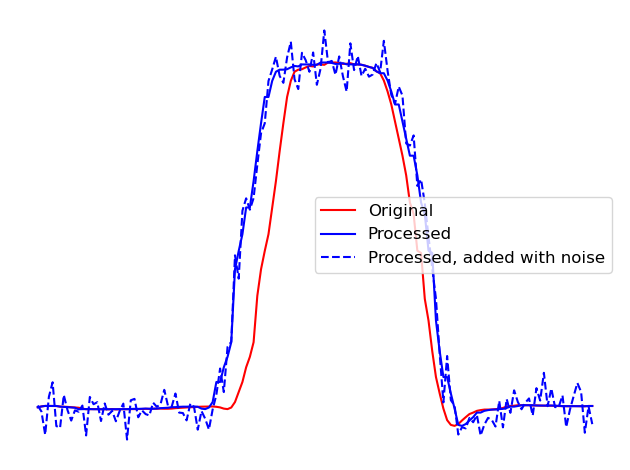

In [13]:
instance_idx = 0
plt.plot(X_train_scaled[instance_idx], color="red", label="Original")
plt.plot(X_train_ps[instance_idx], color="blue", label="Processed")
plt.plot(
    X_train_ps_noise[instance_idx],
    color="blue",
    linestyle="--",
    label="Processed, added with noise",
)
plt.legend(fontsize=12)
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/GunPoint_processed.pdf", format="pdf", bbox_inches="tight")
plt.show()

Store the resulting dataset to `../data_intermediate` 

In [14]:
# Ensure the folder exists
os.makedirs("../data_intermediate", exist_ok=True)

np.savez(
    "../data_intermediate/"
    + dataset_name
    + "_preprocessed_P_"
    + str(P)
    + "_l_"
    + str(l)
    + "_len_"
    + str(final_len)
    + ".npz",
    # For X_train
    X_train=X_train,
    X_train_scaled=X_train_scaled.squeeze(),
    X_train_ps=X_train_ps,
    X_train_ps_noise=X_train_ps_noise,
    y_train=y_train,
    X_train_cuts=X_train_cuts,
    X_train_ps_cuts=X_train_ps_cuts,
    # For X_test
    X_test=X_test,
    X_test_scaled=X_test_scaled.squeeze(),
    X_test_ps=X_test_ps,
    X_test_ps_noise=X_test_ps_noise,
    y_test=y_test,
    X_test_cuts=X_test_cuts,
    X_test_ps_cuts=X_test_ps_cuts,
)